Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

# Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Models
import efficientnet.keras as efn 
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

from keras.models import Model, Sequential
from keras.layers import Input, InputLayer, Convolution2D, Activation, MaxPooling2D, Flatten, Dense, Conv2D, Dropout, Lambda, GlobalAveragePooling2D
from keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from IPython.display import display, Image

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import cv2
from tqdm import tqdm
import os, re, csv

Checking TensorFlow version and GPU Compatability

In [2]:
print("TF version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

TF version: 2.4.1
Num GPUs: 1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1. Data Exploration

Import labels of training images

In [4]:
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Checking for null rows

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


Total number of unique dog breeds

In [6]:
# List of unique breeds
breeds_list = sorted(list(set(labels['breed'])))

unique_breeds = len(breeds_list)
print("Unique breeds:", unique_breeds)

Unique breeds: 120


In [7]:
# delete breeds = list(labels.breed.values)

Checking sample submission file 

Submission requires us to fill the probability values of breeds for each image

In [17]:
sample = pd.read_csv('sample_submission.csv')

In [18]:
sample

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10353,fff1ec9e6e413275984966f745a313b0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


#### 2. Problem solutions

2 ways we will be doing this:

Part 1. Input > Feature Extraction > Classifier > Predictions

Part 2. Input > Neural Network > Predictions

The difference is in 2, Feature Extraction + Classification will be done by the Neural Network itself, while 1 will be more "manual"

#### Part 1 

##### a) Data Pre-processing

We will set the input shape as size of 224x224, with 3 channels for RGB

In [10]:
# 224x224, RGB = 3 channels
input_shape = (224, 224, 3)

Here we will do a count of images for each unique breeds

In [11]:
breeds_arr = dict(zip(breeds_list, range(unique_breeds)))

First we will convert the training+test images to arrays for input to the feature extractor

In [13]:
# Convert training images to array

# The function will go through the directory that contains the images, and will start to convert each image to a matrix of size 224x224x3, and appends it to the array

def images_to_array(data_dir, labels, img_size=(224,224,3)):

    image_id = labels['id']
    image_labels = labels['breed']
    
    # Total number of training images
    data_size = len(image_id)
    
    # Create X and y arrays for training data/labels, fill with 0 first
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    
    # Data and labels
    # Loops through the entire training data images
    for i in tqdm(range(data_size)):
        image_name = image_id[i]
        
        # We get each file name for the individual images
        img_dir = os.path.join(data_dir, image_name+'.jpg') # Append .jpg
        
        # load_img converts the image to pixels to be stored in the array 
        img_pixels = load_img(img_dir, target_size=img_size)
        
        # Append 224x224x3 matrix to X array
        X[i] = img_pixels
        
        # If image breed matches the label, = 1
        image_breed = image_labels[i]
        y[i] = breeds_arr[image_breed]
    
    # One-hot encoder, converting the labels into arrays
    y = to_categorical(y)
    
    return X, y

In [14]:
# Convert test images to array
# Difference is this function does not have image labels ie. y variable

def images_to_array2(data_dir, labels, img_size = (224,224,3)):

    image_id = labels['id']
    
    # Total number of test images 
    data_size = len(image_id)
    
    # Create X array for test data
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        image_name = image_id[i]
        
        # We get each file name for the individual images
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        
        # load_img converts the image to pixels to be stored in the array 
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        
        # Append 224x224x3 matrix to X array
        X[i] = img_pixels
        
    return X

##### b) Training and Test data in array

In [20]:
# Training data

X, y = images_to_array('train/', labels, input_shape)

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [00:23<00:00, 440.44it/s]


Data Size:  (10222, 224, 224, 3)
Label Size:  (10222, 120)


In the X array (training image data), each image will be converted into a matrix of size 224x224x3 (tensor), to visualize, refer to the image below

The X array will have a total of 10222 tensor, each for an image

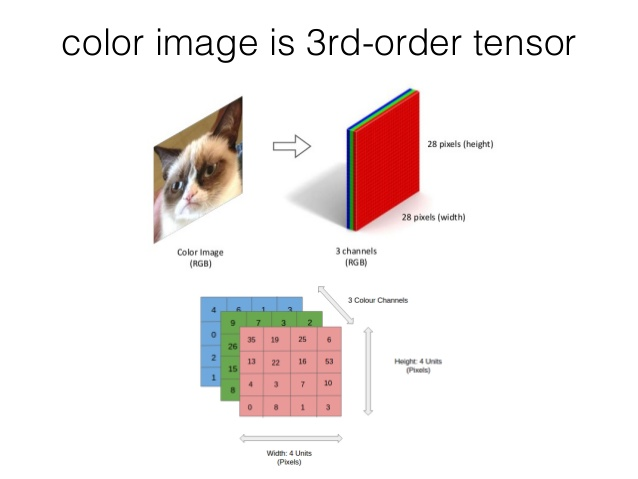

Reference: https://image.slidesharecdn.com/tensordecomposition-170301235239/95/a-brief-survey-of-tensors-5-638.jpg

In [45]:
print('Training Data Size: ', X.shape)

Training Data Size:  (10222, 224, 224, 3)


In [60]:
# Size of first tensor of image

X[0].shape

(224, 224, 3)

In the y array (training image labels), each unique breed will represent a column, where 1=the breed of that image id

10222 rows, 120 columns

In [44]:
print('Training Label Size: ', y.shape)

Training Label Size:  (10222, 120)


In [32]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [19]:
# Test data

test_data = images_to_array2('test/', sample, input_shape)

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [00:29<00:00, 351.32it/s]

Data Size:  (10357, 224, 224, 3)


In [61]:
print('Test Data Size: ', test_data.shape)

Test Data Size:  (10357, 224, 224, 3)


##### c) Feature Extraction

We will be using pre-trained models to extract features from the image data

In [ ]:
# Feature Extraction function

def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    inputs = Input(input_size)
    
    preprocessor = Lambda(data_preprocessor)(inputs)
    
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    
    avg = GlobalAveragePooling2D()(base_model)
    
    feature_extractor = Model(inputs = inputs, outputs = avg)

    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature shape: ', feature_maps.shape)
    
    return feature_maps

##### Using InceptionV3

Training features

In [ ]:
# Extracting training features

inception_features_train = get_features(InceptionV3, preprocess_input, input_shape, X)
#efn_features_train = get_features(efn, preprocess_input, input_shape, X)

Test features

In [ ]:
# Extracting test features

inception_features_test = get_features(InceptionV3, preprocess_input, input_shape, test_data)

Split to train / validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(inception_features_train, y)

##### d) Feeding extracted features to classifier

##### 1. Using a simple neural network as a classifier

Building the model

In [ ]:

# 2048
inputs = keras.Input(shape=inception_features_train.shape[1:])

x = Dense(256, activation='relu')(inputs)
x = Dropout(0.25)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(unique_breeds, activation='softmax')(x) # Classification layer

f1 = keras.Model(inputs, outputs, name='DNN')

f1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

f1.summary()

Setting callbacks

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'inceptionfeatures_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

Training the model

In [ ]:
bs = 256
epoch = 30

In [ ]:
f1_h = f1.fit(X_train, y_train, 
              batch_size=bs, 
              epochs=epoch, 
              validation_split=0.1, 
              callbacks=[model_checkpoint, earlystopping])

Model Evaluation

In [ ]:
score1 = f1.evaluate(x=X_val, y=y_val, verbose=1)

print(f' Loss: {score1[0]}\n Accuracy: {score1[1]}')

In [ ]:
plt.plot(f1_h.history['accuracy'])
plt.plot(f1_h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(f1_h.history['loss'])
plt.plot(f1_h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test data

In [ ]:
f1_pred = f1.predict(inception_features_test, batch_size=bs)

##### 2. Using Random Forest Classifier

In [ ]:
# Initialize 100 trees to be generated
clf = RandomForestClassifier(n_estimators=100, verbose=2)

Fitting

In [ ]:
clf.fit(X_train, y_train)

Prediction on validation set

In [ ]:
f2_pred_val = clf.predict(X_val)

Evaluation

In [ ]:
print("Accuracy:", accuracy_score(y_val, f2_pred_val))

Prediction on test set

In [ ]:
f2_pred = clf.predict(inception_features_test)

##### e) Predictions 

Here we compare the results of using different classifiers 

##### 1. Simple Neural Network Classifier

In [ ]:
print(f' Loss: {score1[0]}\n Accuracy: {score1[1]}')

##### 2. Random Forest Classifier

In [ ]:
print("Accuracy:", accuracy_score(y_val, f2_pred_val))

##### f) Output to submission file

In [ ]:
# f1_df = sample

# for x in breeds_list:
#     f1_df[x] = f1_pred[:, breeds_arr[x]]

# f1_df.to_csv('submission_feature_extraction.csv', index=None)

Free up memory

In [ ]:
# del X, y, test_data

In [ ]:
# %reset -f 

#### Part 2 

##### a) Data Pre-processing

In [ ]:
labels2 = labels

In [11]:
labels2['id'] = labels2['id'] + '.jpg'

Here we split our labels data into training and validation set

In [12]:
train, val = train_test_split(labels2, test_size=0.2, shuffle=True)

In [13]:
print("Train shape:", train.shape)
print("Validation shape:", val.shape)

Train shape: (8177, 2)
Validation shape: (2045, 2)


Image data augmentation


We "create" more training data from existing data by doing image manipulation (Rotate/Zoom/Scaling/Contrast) (Get more variants of image for neural network to learn)

This will help improve the performance of the neural network

For more info: https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

By using keras image data generator it will feed each image into the network so we do not need to do manual feature extraction

In [62]:
# Datagen

train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255, # Scale/Normalize pixel value from range [0,255] to [0,1], RGB coeff in 0-255 too high for model to process
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_gen = ImageDataGenerator(
    rescale=1./255)

test_gen = ImageDataGenerator(
            rescale=1./255)

Retrieve our training/val/test sets

In [63]:
# Training / Validation / Test set

bs = 64

training_set = train_gen.flow_from_dataframe(
    dataframe=train,
    directory='train/',
    x_col="id",
    y_col="breed",
    target_size=(224, 224), # Has to match input_shape
    class_mode="categorical",
    batch_size=bs,
    seed=42,
    shuffle=True
)

validation_set = val_gen.flow_from_dataframe(
    dataframe=val,
    directory='train/',
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=bs,
    seed=42,
    shuffle=True
)

test_set = test_gen.flow_from_directory(
    '',
    target_size = (224, 224),
    batch_size = bs,
    classes=['test'],
    seed=42,
    shuffle=False
)

NameError: name 'train' is not defined

In [16]:
step_size_train = training_set.n // bs
step_size_val = validation_set.n // bs

##### b) Neural Networks

##### 1. CNN (Convolutional Neural Network)

Building a CNN Model from scratch

In [19]:
# Create a sequential model
inputs = keras.Input(shape=input_shape)

x = Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[224, 224, 3])(inputs)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)

outputs = Dense(unique_breeds, activation='softmax')(x) # Classification layer

cnn = Model(inputs, outputs, name='CNN')

cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

View summary of the CNN model

In [77]:
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0       

In [ ]:
model_plot = tf.keras.utils.plot_model(cnn, show_shapes=True)
display(model_plot)

Checkpoints

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'cnn_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)

# If the validation loss doesn't improve, reduce the learning rate to 0.2 times it's previous value

# New LR = Old LR * factor
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3)

Training the CNN model

In [ ]:
# Samples // batch size = # of batches
# 1 epoch trains # of batches
# Weights updated after each batch 

epochs = 10

history = cnn.fit(training_set,
          epochs=epochs,
          steps_per_epoch=step_size_train,
          validation_data=validation_set,
          validation_steps=step_size_val,
          callbacks=[model_checkpoint, earlystopping, reduce_lr], shuffle=True, verbose=1)

Save final CNN model

In [ ]:
cnn.save('models/final_cnn.h5')

Model Evaluation

In [ ]:
# Loss - Accuracy 

score3 = cnn.evaluate(validation_set, steps=step_size_val, verbose=1)
print(f' Loss: {score3[0]}\n Accuracy: {score3[1]}')

Accuracy + Loss plot

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test set

In [ ]:
cnn_y_pred = cnn.predict(test_set, verbose=1)

##### 2. EfficientNet

Using pre-trained EfficientNet model in keras (Transfer Learning)

In [17]:
# Set include_top=False, as we will be using our own classification layer
# Using imagenet weights

eff = efn.EfficientNetB0(weights='imagenet', input_shape=(224,224,3), include_top=False)

Building classification layer on top

In [18]:
inputs = keras.Input(shape=(224,224,3))

x = eff(inputs)

x = GlobalAveragePooling2D()(x)

x = Dense(units=128,activation='relu')(x)

outputs = Dense(unique_breeds, activation='softmax')(x) # Sum of Prob = 1 

effnet = keras.Model(inputs, outputs, name='EfficientNet')

effnet.layers[1].trainable=False

effnet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) # Multi-class, Labels in one-hot, use categorical_crossentropy

View Summary of the EfficientNet model

In [19]:
effnet.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               15480     
Total params: 4,229,012
Trainable params: 179,448
Non-trainable params: 4,049,564
_________________________________________________________________


In [64]:
# model_plot = tf.keras.utils.plot_model(effnet, show_shapes=True)
# display(model_plot)

Checkpoints

In [21]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'efnnet_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

# If the validation loss doesn't improve, reduce the learning rate to 0.2 times it's previous value

# New LR = Old LR * factor
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3)

Training the model

In [22]:
epochs = 30

In [23]:
history2 = effnet.fit(training_set,
          epochs=epochs,
          steps_per_epoch=step_size_train,
          validation_data=validation_set,
          validation_steps=step_size_val,
          callbacks=[model_checkpoint, earlystopping, reduce_lr], verbose=1)

Epoch 1/30
127/127 [==============================] - 108s 753ms/step - loss: 4.0719 - accuracy: 0.1434 - val_loss: 1.6682 - val_accuracy: 0.5766
Epoch 2/30
127/127 [==============================] - 89s 703ms/step - loss: 1.9518 - accuracy: 0.4950 - val_loss: 1.2324 - val_accuracy: 0.6613
Epoch 3/30
127/127 [==============================] - 89s 703ms/step - loss: 1.6160 - accuracy: 0.5551 - val_loss: 1.1017 - val_accuracy: 0.6794
Epoch 4/30
127/127 [==============================] - 92s 727ms/step - loss: 1.3813 - accuracy: 0.6156 - val_loss: 1.0669 - val_accuracy: 0.6759
Epoch 5/30
127/127 [==============================] - 93s 732ms/step - loss: 1.2923 - accuracy: 0.6356 - val_loss: 1.0529 - val_accuracy: 0.6729
Epoch 6/30
127/127 [==============================] - 92s 727ms/step - loss: 1.2012 - accuracy: 0.6628 - val_loss: 1.0191 - val_accuracy: 0.7006
Epoch 7/30
127/127 [==============================] - 92s 725ms/step - loss: 1.1594 - accuracy: 0.6707 - val_loss: 1.0173 - val_a

Save final model

In [24]:
effnet.save('models/final_effnetb0.h5')

Model Evaluation

In [26]:
score4 = effnet.evaluate(validation_set, steps=step_size_val, verbose=1)
print(f' Loss: {score4[0]}\n Accuracy: {score4[1]}')

31/31 [==============================] - 6s 179ms/step - loss: 0.9260 - accuracy: 0.73082s - l
 Loss: 0.9259665608406067
 Accuracy: 0.7308467626571655


Accuracy + Loss Plot

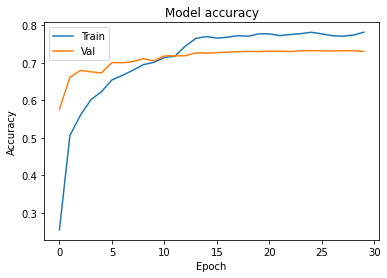

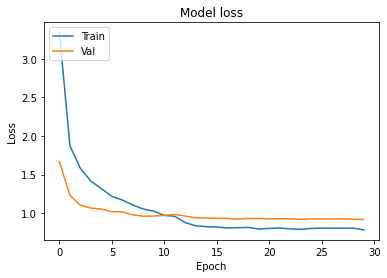

In [27]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test set

In [29]:
efnnet_y_pred = effnet.predict(test_set, verbose=1)

162/162 [==============================] - 40s 242ms/step


##### c) Models Evaluation

In [ ]:
print("CNN:\n")
print(f' Loss: {score3[0]}\n Accuracy: {score3[1]}')
print("\n")
print("EfficientNet:\n")
print(f' Loss: {score4[0]}\n Accuracy: {score4[1]}')

-- 

##### d) Submission

In [30]:
sample2 = pd.read_csv('sample_submission.csv')

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10353,fff1ec9e6e413275984966f745a313b0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


Get list of filenames

In [31]:
files = test_set.filenames
ids = []

for name in files:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    ids.append(m)

Map each prediction value to its respective class for each image/file

In [32]:
sample2['id'] = ids
sample2.iloc[:,1:] = efnnet_y_pred

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,test\000621fb3cbb32d8935728e48679680e,1.118752e-07,9.909627e-06,9.689343e-10,1.108678e-10,3.863621e-09,3.802730e-08,8.445660e-08,1.482428e-09,5.085420e-09,...,9.586721e-08,2.560177e-07,1.147801e-10,1.118385e-08,1.119525e-09,3.078751e-08,1.178350e-08,4.946136e-09,4.200325e-09,2.343702e-07
1,test\00102ee9d8eb90812350685311fe5890,9.974036e-07,4.804367e-07,2.671979e-08,6.637133e-08,4.238565e-05,5.378876e-07,1.861682e-07,8.644247e-07,9.794309e-09,...,1.005695e-05,1.578996e-06,1.910249e-07,2.711056e-06,5.436159e-07,7.477004e-08,9.774947e-05,3.741498e-07,6.126218e-07,2.239914e-08
2,test\0012a730dfa437f5f3613fb75efcd4ce,3.627980e-06,2.746189e-02,3.658567e-07,2.277810e-04,1.077051e-05,1.008959e-06,1.496980e-06,6.310680e-09,2.452861e-07,...,1.732889e-05,7.994785e-08,2.246557e-05,1.067380e-04,1.922098e-04,1.290043e-03,8.681233e-07,6.191797e-05,2.457272e-05,5.310518e-07
3,test\001510bc8570bbeee98c8d80c8a95ec1,8.174382e-03,8.583743e-05,9.526138e-06,1.756725e-04,4.287047e-03,8.404830e-03,3.505893e-05,2.586749e-04,1.634876e-05,...,1.462206e-04,1.832008e-05,7.292271e-04,9.703080e-06,2.590578e-04,8.029072e-07,2.245853e-06,2.094897e-03,3.914822e-07,1.328343e-04
4,test\001a5f3114548acdefa3d4da05474c2e,2.905964e-03,8.515082e-04,1.342599e-06,5.777601e-06,2.633478e-05,1.399249e-07,2.325099e-03,2.261198e-07,6.450874e-07,...,5.052771e-05,6.055498e-06,6.873390e-08,3.228758e-08,1.007408e-07,1.225534e-06,1.519684e-04,3.188874e-07,5.631857e-05,9.543112e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,test\ffeda8623d4eee33c6d1156a2ecbfcf8,9.543951e-07,1.002706e-03,1.990028e-08,6.274511e-06,3.459076e-07,5.158451e-08,8.217328e-08,4.456953e-07,8.123421e-08,...,5.556060e-03,8.174772e-07,2.694981e-06,6.728736e-06,2.612930e-06,1.896101e-05,7.108382e-07,1.890039e-06,5.652658e-05,1.742595e-06
10353,test\fff1ec9e6e413275984966f745a313b0,9.412607e-10,1.895617e-04,1.310843e-07,8.084534e-04,3.342884e-04,2.721947e-06,2.704221e-06,1.868969e-06,2.976544e-03,...,3.071269e-07,5.924798e-07,1.384878e-01,1.532504e-04,1.409750e-01,2.013208e-05,3.110091e-08,1.732544e-03,6.585546e-06,1.903715e-06
10354,test\fff74b59b758bbbf13a5793182a9bbe4,1.656962e-07,7.614918e-07,1.901184e-03,1.355927e-07,6.397018e-07,6.014382e-06,5.502384e-06,5.627868e-05,1.420696e-06,...,4.703661e-08,1.217854e-05,5.167341e-06,1.170218e-07,1.204374e-06,1.883938e-05,3.614727e-08,7.036508e-06,4.117345e-07,7.890255e-06
10355,test\fff7d50d848e8014ac1e9172dc6762a3,9.025064e-04,6.530363e-05,2.010153e-06,3.958363e-06,2.840606e-05,4.949882e-07,1.309310e-03,1.880876e-06,6.257419e-06,...,8.452114e-04,2.720734e-05,3.384793e-06,2.528307e-07,9.359510e-06,1.719062e-05,3.895808e-03,9.411913e-07,2.443067e-04,4.756070e-03


Output to csv

In [33]:
submission = sample2.set_index('id')
submission.to_csv('submission.csv')

In [34]:
submission.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
test\000621fb3cbb32d8935728e48679680e,1.118752e-07,9.909627e-06,9.689343e-10,1.108678e-10,3.863621e-09,3.802730e-08,8.445660e-08,1.482428e-09,5.085420e-09,3.449150e-06,...,9.586721e-08,2.560177e-07,1.147801e-10,1.118385e-08,1.119525e-09,3.078751e-08,1.178350e-08,4.946136e-09,4.200325e-09,2.343702e-07
test\00102ee9d8eb90812350685311fe5890,9.974036e-07,4.804367e-07,2.671979e-08,6.637133e-08,4.238565e-05,5.378876e-07,1.861682e-07,8.644247e-07,9.794309e-09,1.539629e-06,...,1.005695e-05,1.578996e-06,1.910249e-07,2.711056e-06,5.436159e-07,7.477004e-08,9.774947e-05,3.741498e-07,6.126218e-07,2.239914e-08
test\0012a730dfa437f5f3613fb75efcd4ce,3.627980e-06,2.746189e-02,3.658567e-07,2.277810e-04,1.077051e-05,1.008959e-06,1.496980e-06,6.310680e-09,2.452861e-07,2.108301e-05,...,1.732889e-05,7.994785e-08,2.246557e-05,1.067380e-04,1.922098e-04,1.290043e-03,8.681233e-07,6.191797e-05,2.457272e-05,5.310518e-07
test\001510bc8570bbeee98c8d80c8a95ec1,8.174382e-03,8.583743e-05,9.526138e-06,1.756725e-04,4.287047e-03,8.404830e-03,3.505893e-05,2.586749e-04,1.634876e-05,5.396770e-07,...,1.462206e-04,1.832008e-05,7.292271e-04,9.703080e-06,2.590578e-04,8.029072e-07,2.245853e-06,2.094897e-03,3.914822e-07,1.328343e-04
test\001a5f3114548acdefa3d4da05474c2e,2.905964e-03,8.515082e-04,1.342599e-06,5.777601e-06,2.633478e-05,1.399249e-07,2.325099e-03,2.261198e-07,6.450874e-07,3.547666e-08,...,5.052771e-05,6.055498e-06,6.873390e-08,3.228758e-08,1.007408e-07,1.225534e-06,1.519684e-04,3.188874e-07,5.631857e-05,9.543112e-04


#### 3. Visualizing image features on Tensorboard Projector

Will be using features extracted from Part 1

Involves Dimensionality Reduction (PCA) to display the images on a 3D plane in the projector

In [ ]:
# Start up tensorboard
%load_ext tensorboard

In [ ]:
len(inception_features_test)

1. Create feature vectors + metadata (labels)

In [ ]:
# Export to tsv file for embedding projector

# Features
np.savetxt("inception_features_test.tsv", inception_features_test, delimiter="\t")

Labels for test data

In [ ]:
meta_arr = f1_pred

# Take the highest value/"predicted" breed for each test img/file
meta_arr = (meta_arr == meta_arr.max(axis=1, keepdims=1)).astype(int)

In [ ]:
meta_arr[0]

In [ ]:
# Convert to DF - Easier to read
meta_df = sample

for x in breeds_list:
    meta_df[x] = meta_arr[:, breeds_arr[x]]

In [ ]:
meta_df

In [ ]:
# Reversing OHE array

# Label each img/file to its predicted breed
def reverse_OHE(row):
    for c in meta_df.columns:
        if row[c]==1:
            return c

In [ ]:
reverse_meta_df = pd.DataFrame(meta_df.apply(reverse_OHE, axis=1))

In [ ]:
# Joining img id 
reverse_meta_df = reverse_meta_df.join(meta_df['id'])

In [ ]:
# Rename headers
reverse_meta_df.columns = ['breed', 'id']

In [ ]:
reverse_meta_df

In [ ]:
# Export to tsv file 

metadata = reverse_meta_df[['id', 'breed']].to_csv('metadata.tsv', sep='\t', index=False)

2. Create sprite image (Collage) to be displayed on the projector

In [ ]:
! magick montage test/*.jpg -tile 103x103 -geometry 50x50! sprite.jpg
print("Done")

3. Create config file

In [ ]:
# projector_config.pbtxt should look like this

# embeddings {
#   tensor_path: "inception_features_test.tsv"
#   metadata_path: "metadata.tsv"
#   sprite {
#     image_path: "sprite.jpg"
#     single_image_dim: 50
#     single_image_dim: 50
#   }
# }

# with open('projector_config.pbtxt', 'w') as file:
#     file.write('embeddings { tensor_path: "inception_features_test.tsv" metadata_path: "metadata.tsv" sprite { image_path: "sprite.jpg" single_image_dim: 50 single_image_dim: 50 } }')


Run tensorboard locally

In [ ]:
! tensorboard --logdir .

Open: http://localhost:6006/#projector

References

[1] https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

[2] https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

[3] https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.&text=The%20rectified%20linear%20activation%20function%20overcomes%20the%20vanishing%20gradient%20problem,learn%20faster%20and%20perform%20better

[4] https://lisaong.github.io/mldds-courseware/01_GettingStarted/numpy-tensor-slicing.slides.html

[5] https://medium.com/@kumon/visualizing-image-feature-vectors-through-tensorboard-b850ce1be7f1
